In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import matplotlib
import glob
import re
import cv2
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.patches as patches
import matplotlib.colors as colors
import PIL
import math
%matplotlib inline
import seaborn as sns
import json
from scipy.stats import fisher_exact, ttest_ind
from collections import Counter
from pprint import pprint
import pickle
import sys
from anndata import AnnData

sys.path.append("/booleanfs2/sahoo/Hegemon/")
sys.path = ["/booleanfs2/sahoo/BoNE/"] + sys.path
import StepMiner as smn
import HegemonUtil as hu
acolor = ["#00CC00", "#D8A03D","#EC008C",
          'cyan', "#B741DC", "#808285",
          'blue', 'black', 'green', 'red',
          'orange', 'brown', 'pink', 'purple']

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

import bone
reload(bone)


class IMMAnalysis(bone.IBDAnalysis):

    def __init__(self):
        bone.IBDAnalysis.__init__(self)

def getSViP():
    l1 = [bone.readList("covid/iav-list-1.txt")[0:20]] # 20 gene signature
    wt1 = [1]
    return wt1, l1

def getViP():
    l1 = [bone.readList("covid/list-2.txt")] # 166 gene signature
    wt1 = [1]
    return wt1, l1

def getSimpleName(gene_groups, h):
    res = []
    for s in gene_groups:
        s1 = set()
        for g in s:
            for id1 in h.getIDs(g):
                name = h.getSimpleName(id1)
                if name != "" and name != "---":
                    s1.add(name)
        res.append(s1)
    return res

def getMacGeneGroups(order = None, weight = None, debug = 1):
    reload(hu)
    db = hu.Database("/booleanfs2/sahoo/Hegemon/explore.conf")
    h = hu.Hegemon(db.getDataset("GL4"))
    h.init()
    h.initPlatform()
    h.initSurv()
    data_item = []
    dir1 = "/booleanfs2/sahoo/Data/Macrophage/BN/"
    with open(dir1 + 'figures/path-1.json') as data_file:
        data_item += json.load(data_file)
    with open(dir1 + 'figures/path-0.json') as data_file:
        l1 = json.load(data_file)
        data_item[5] = l1[5]
        data_item[6] = l1[6]
    with open(dir1 + 'figures/path-2.json') as data_file:
        data_item += json.load(data_file)
    with open(dir1 + 'figures/path-3.json') as data_file:
        data_item += json.load(data_file)
    with open(dir1 + 'figures/path-4.json') as data_file:
        data_item += json.load(data_file)
    cfile = dir1 + "figures/mac-net-cls.txt"
    if not os.path.isfile(cfile):
        print ("Can't open file {0} <br>".format(cfile))
        exit()
    fp = open(cfile, "r")
    nodelist = {}
    nhash = {}
    for line in fp:
        line = line.strip();
        ll = line.split("\t");
        nodelist[ll[0]] = ll[2:]
        for i in ll[2:]:
            nhash[i] = ll[0];
    fp.close();
    gene_groups = []
    for i in range(len(data_item)):
        gene_groups.append(set())
        gn = data_item[i][2][0][0]
        for g in data_item[i][2]:
            gene_groups[i].add(g[0])
            if g[0] in nodelist:
                for k in nodelist[g[0]]:
                    gene_groups[i].add(k)
        for g in data_item[i][3]:
            gene_groups[i].add(g)
            if g in nodelist:
                for k in nodelist[g]:
                    gene_groups[i].add(k)
        if debug == 1:
            print (i, gn, h.getSimpleName(gn), data_item[i][0], len(gene_groups[i]))
    print([len(s) for s in gene_groups])
    if order is None:
        order = [1, 3, 4, 5];
        order = [35]
        order = [43, 44, 45];
        order = [8, 9, 10]
    gene_groups = [gene_groups[i] for i in order]
    print([len(s) for s in gene_groups])
    gene_groups = getSimpleName(gene_groups, h)
    print([len(s) for s in gene_groups])
    if weight is None:
        weight = [-1, 1, 2, 3]
        weight = [-1, -2, -3]
        weight = [-1]
        weight = [-1, -2, -3]
    print (weight)
    genes = bone.readGenes(dir1 + "figures/cluster-names.txt")
    return genes, weight, gene_groups

def getCls13a14a3():
    order = [13, 14, 3]
    wt1 = [-1, 1, 2]
    nx = [0, 1, 4, 5, 6, 8, 9, 10, 16, 17, 19, 20, 21, 25, 28]
    genes, wt1, l1 = getMacGeneGroups([nx[i] for i in order], wt1, 0)
    return wt1, l1

def getCls13():
    order = [13]
    wt1 = [-1]
    nx = [0, 1, 4, 5, 6, 8, 9, 10, 16, 17, 19, 20, 21, 25, 28]
    genes, wt1, l1 = getMacGeneGroups([nx[i] for i in order], wt1, 0)
    return wt1, l1

def getCls14a3():
    order = [14, 3]
    wt1 = [1, 2]
    nx = [0, 1, 4, 5, 6, 8, 9, 10, 16, 17, 19, 20, 21, 25, 28]
    genes, wt1, l1 = getMacGeneGroups([nx[i] for i in order], wt1, 0)
    return wt1, l1

def processOne(ana, order, wt1, ax1, ax2, id1 = None, l1=None, violin=1):
    genes = []
    if (l1 is None):
        nx = [0, 1, 4, 5, 6, 8, 9, 10, 16, 17, 19, 20, 21, 25, 28]
        sel = 2
        genes, wt1, l1 = getMacGeneGroups([nx[i] for i in order], wt1, 0)
    ana.orderData(l1, wt1)
    if id1 is None:
        params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1
,
                'genes': genes, 'ax': ax1, 'acolor': acolor}
        ax = ana.printTitleBar(params)
        res = ana.getROCAUC()
        ax.text(len(ana.cval[0]), 4, res)
        if (violin == 1):
            params['ax'] = ax2
            params['vert'] = 0
            ax = ana.printViolin(None, params)
        else:
            ax = ana.densityPlot(ax2, acolor)
        return ana
    else:
        params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1
,
                'genes': genes, 'acolor': acolor}
        ax = ana.printTitleBar(params)
        if (violin == 1):
            ax = ana.printViolin(None, {'vert':0})
        else:
            ax = ana.densityPlot()
    expr = ana.h.getExprData(id1)
    c = [acolor[ana.aval[i]] for i in ana.order]
    a = [ana.aval[i] for i in ana.order]
    x = [float(expr[i]) for i in ana.order]
    y = [ana.f_ranks[i - ana.h.start] for i in ana.order]
    df = pd.DataFrame()
    df['x'] = x
    df['y'] = y
    df['c'] = c
    df['a'] = a
    ax = df.plot('x', 'y', c=c, kind = 'scatter')
    ana.addAxes(ax)
    for i in range(len(ana.atypes)):
        cond1 = (df['a'] == i)
        if (sum(cond1) > 0):
            s1 = np.max(df[cond1]['y']) - np.min(df[cond1]['y'])
            s2 = np.max(df[cond1]['x']) - np.min(df[cond1]['x'])
            df.loc[cond1, 'y'] += (np.mean(df[cond1]['x']) - df.loc[cond1, 'x']) * (s1+1) / (s2+1)
            df.loc[cond1, 'x'] -= (np.mean(df[cond1]['y']) - df.loc[cond1, 'y']) * (s2+1) / (s1+1)
    ax = df.plot('x', 'y', c=c, kind = 'scatter')
    ana.addAxes(ax)
    from sklearn.linear_model import LinearRegression
    linreg = LinearRegression(normalize=True)
    linreg.fit(np.array(df['x']).reshape(-1, 1),df['y'])
    y_pred = linreg.predict(np.array(df['x']).reshape(-1, 1))
    df['y1'] = (df['y'] - y_pred)
    ax = df.plot('x', 'y1', c=c, kind = 'scatter')
    ana.addAxes(ax)
    ana.f_ranks = df['y1']
    ana.i1 = [ana.order[i] for i in np.argsort(ana.f_ranks)]
    ana.f_ranks = [0 for i in ana.h.aRange()]
    for i in range(len(ana.order)):
        ana.f_ranks[ana.order[i] - ana.h.start] = df['y1'][i]
    index = np.array([i - ana.h.start for i in ana.i1])
    ana.cval = np.array([[ana.aval[i] for i in ana.i1]])
    ana.data = np.array([ana.expr[i] for i in ana.ind_r])[:,index]

    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
                  'genes': genes, 'ax': ax1, 'acolor': acolor}
    ax = ana.printTitleBar(params)
    if (violin == 1):
        params['ax'] = ax2
        params['vert'] = 0
        ax = ana.printViolin(None, params)
    else:
        ax = ana.densityPlot(ax2, acolor)

    return ana

def processDataHnorm(ana, id1 = None):
    fig = plt.figure(figsize=(15,4), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax1 = plt.subplot2grid((4, 3), (0, 0))
    ax2 = plt.subplot2grid((4, 3), (1, 0), rowspan=3)
    ax3 = plt.subplot2grid((4, 3), (0, 1))
    ax4 = plt.subplot2grid((4, 3), (1, 1), rowspan=3)
    ax5 = plt.subplot2grid((4, 3), (0, 2))
    ax6 = plt.subplot2grid((4, 3), (1, 2), rowspan=3)
    order = [13]
    wt1 = [-1]
    processOne(ana, order, wt1, ax1, ax2, id1)
    order = [14, 3]
    wt1 = [1, 2]
    processOne(ana, order, wt1, ax3, ax4, id1)
    order = [13, 14, 3]
    wt1 = [-1, 1, 2]
    processOne(ana, order, wt1, ax5, ax6, id1)
    return fig

def processDataHMm(ana, violin=1):
    nx = [0, 1, 4, 5, 6, 8, 9, 10, 16, 17, 19, 20, 21, 25, 28]
    sel = 2
    order = [13]
    wt1 = [-1]
    genes, wt1, l1 = getMacGeneGroups([nx[i] for i in order], wt1, 0)
    ana.convertMm(l1, genes)
    ana.orderData(ana.gene_groups, wt1)
    print(" ".join([str(ana.atype[i]) for i in ana.i1]))
    #ana.normMacrophageGene("TYROBP", {"thr":1})
    #ana.normMacrophageGene("FCER1G", {"thr":3, "tval":6.5, "select":sel})
    print(len(ana.col_labels), len(ana.row_ids))
    fig = plt.figure(figsize=(15,4), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax = plt.subplot2grid((4, 3), (0, 0))
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
              'genes': genes, 'ax': ax, 'acolor': acolor}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    ax.text(len(ana.cval[0]), 4, ",".join(res))
    ax = plt.subplot2grid((4, 3), (1, 0), rowspan=3)
    ax2 = plt.subplot2grid((4, 3), (0, 1))
    ax3 = plt.subplot2grid((4, 3), (1, 1), rowspan=3)
    if (violin == 1):
        params['ax'] = ax
        params['vert'] = 0
        ax = ana.printViolin(None, params)
        ax.set_ylabel("Violin - Cluster \\#13")
    else:
        ax = ana.densityPlot(ax, acolor)
        ax.set_ylabel("Density - Cluster \\#13")
    #plt.tight_layout()
    order = [14, 3]
    wt1 = [1, 2]
    genes, wt1, l1 = getMacGeneGroups([nx[i] for i in order], wt1, 0)
    ana.convertMm(l1, genes)
    ana.orderData(ana.gene_groups, wt1)
    print(" ".join([str(ana.atype[i]) for i in ana.i1]))
    #ana.normMacrophageGene("TYROBP", {"thr":1})
    #ana.normMacrophageGene("FCER1G", {"thr":3, "tval":6.5, "select":sel})
    print(len(ana.col_labels), len(ana.row_ids))
    params.update({'ax':ax2})
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    ax.text(len(ana.cval[0]), 4, ",".join(res))
    if (violin == 1):
        params['ax'] = ax3
        params['vert'] = 0
        ax = ana.printViolin(None, params)
        ax.set_ylabel("Violin - Cluster \\#14-3")
    else:
        ax = ana.densityPlot(ax3, acolor)
        ax.set_ylabel("Density - Cluster \\#14-3")
    ax2 = plt.subplot2grid((4, 3), (0, 2))
    ax3 = plt.subplot2grid((4, 3), (1, 2), rowspan=3)
    order = [13, 14, 3]
    wt1 = [-1, 1, 2]
    genes, wt1, l1 = getMacGeneGroups([nx[i] for i in order], wt1, 0)
    ana.convertMm(l1, genes)
    ana.orderData(ana.gene_groups, wt1)
    print(" ".join([str(ana.atype[i]) for i in ana.i1]))
    #ana.normMacrophageGene("TYROBP", {"thr":1})
    #ana.normMacrophageGene("FCER1G", {"thr":3, "tval":6.5, "select":sel})
    print(len(ana.col_labels), len(ana.row_ids))
    params.update({'ax':ax2})
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    ax.text(len(ana.cval[0]), 4, ",".join(res))
    if (violin == 1):
        params['ax'] = ax3
        params['vert'] = 0
        ax = ana.printViolin(None, params)
        ax.set_ylabel("Violin - Cluster \\#13-14-3")
    else:
        ax = ana.densityPlot(ax3, acolor)
        ax.set_ylabel("Density - Cluster \\#13-14-3")
    return fig

def getHigh(ana, tn=0, thr=2.0, nthr=10):
    order = [i for i in ana.order if ana.aval[i] == tn]
    fp = ana.h.fp;
    fp.seek(0, 0);
    h = fp.readline();
    res = []
    index = 0
    for line in fp:
        line = line.strip();
        ll = line.split("\t")
        l1 = [i for i in order if i < len(ll) and
              ll[i] != '' and float(ll[i]) > thr]
        if len(l1) > nthr:
            res.append([ll[0], ana.h.getSimpleName(ll[0]), len(l1)])
        index += 1
        if (index % 1000) == 0:
            print(index)
    return res

def getHighJava(ana, tn=0, thr=2.0, nthr=10):
    order = [i for i in ana.order if ana.aval[i] == tn]
    ofh = open(".arrorder", "w")
    for i in order:
        ofh.write(ana.headers[i] + "\n")
    ofh.close()
    from subprocess import check_output
    cmd = ['java', '-cp', '/booleanfs2/sahoo/Hegemon',
           'tools.Hegemon', 'high', ana.h.getPre(),
           '.arrorder', str(thr), str(nthr)]
    result = check_output(cmd, input='')
    l1 = result.decode('utf-8').split('\n')
    res = [k.split('\t') for k in l1 if k != '']
    res = [[k[0], ana.h.getSimpleName(k[0]), k[1]] for k in res]
    return res

def getCls14a3v2():
    l1 = [['RPS16', 'RPS21', 'RPL6', 'CCDC88A', 'RPL3', 'RPS15A', 'RPL14',
        'PCBP2', 'RPL23', 'RPL13', 'METTL7A'],
        ['CLEC10A', 'ANXA4', 'UBL3', 'RPS21', 'RPL6', 'RPS15A', 'ARL4C',
            'RPL14', 'HEXA', 'METTL7A', 'RPS16']]
    l1 = [['RPL24', 'NACA', 'RPS16', 'RPS21', 'RPL6', 'CCDC88A',
        'RPL3', 'RPS15A', 'EEF1B2', 'RPL14', 'PCBP2', 'RPL23',
        'RPL13', 'METTL7A', 'EEF2'],
        ['CLEC10A', 'INPP5A', 'NACA', 'ANXA4', 'UBL3', 'RPS21',
            'ITSN1', 'RPL24', 'RPS15A', 'ARL4C', 'RPL14', 'RPL6',
            'HEXA', 'METTL7A', 'EEF2', 'RPS16']]
    wt1 = [1, 2]
    return wt1, l1

bone.getCls13 = getCls13
bone.getCls14a3 = getCls14a3
bone.getCls13a14a3 = getCls13a14a3
bone.getCls14a3v2 = getCls14a3v2

def getIDhash(adata):
    idhash = {}
    for i in range(len(adata.raw.var['gene_symbols'])):
        k = adata.raw.var['gene_symbols'][i]
        v = adata.raw.var['gene_ids'][i]
        if k not in idhash:
            idhash[k] = []
        idhash[k] += [v]
    return idhash

def getRanks3(gene_groups, adata):
    idhash = getIDhash(adata)
    expr = []
    row_labels = []
    row_ids = []
    row_numhi = []
    ranks = []
    g_ind = 0
    counts = []
    for s in gene_groups:
        count = 0
        avgrank = [0] * adata.raw.n_obs
        for gn in s:
            if gn not in idhash:
                continue
            e = adata.raw.obs_vector(gn)
            v = e
            if (np.max(v) - np.min(v)) <= 0:
                continue
            t = hu.getThrData(v)
            te = []
            for i in range(len(e)):
                if e[i] == "":
                    v1 = - t[3] / 3;
                else:
                    v1 = (float(e[i]) - t[3]) / 3;
                if np.std(v) > 0:
                    v1 = v1 / np.std(v)
                avgrank[i] += v1
                te.append(v1)
            expr.append(te)
            row_labels.append(gn)
            row_ids.append(idhash[gn][0])
            v1 = [g_ind, sum(v > t[3])]
            if g_ind > 3:
                v1 = [g_ind, sum(v <= t[3])]
            else:
                v1 = [g_ind, sum(v > t[3])]
            row_numhi.append(v1)
            count += 1
            #if count > 200:
            #    break
        ranks.append(avgrank)
        g_ind += 1
        counts += [count]
    print (counts)
    return ranks, row_labels, row_ids, row_numhi, expr
def computeSMART(adata, org='Hs'):
    wt1, l1 = bone.getCls13()
    if org is 'Mm':
        l1 = bone.getGroupsMm(l1)
    ranks, row_labels, row_ids, row_numhi, expr = getRanks3(l1, adata)
    f_ranks = bone.mergeRanks(range(adata.raw.n_obs), 0, ranks, wt1)
    adata.obs['c13'] = f_ranks

    wt1, l1 = bone.getCls14a3()
    if org is 'Mm':
        l1 = bone.getGroupsMm(l1)
    ranks, row_labels, row_ids, row_numhi, expr = getRanks3(l1, adata)
    f_ranks = bone.mergeRanks(range(adata.raw.n_obs), 0, ranks, wt1)
    adata.obs['c14_3'] = f_ranks
    adata.obs['c14'] = ranks[0]
    adata.obs['c3'] = ranks[1]
    return adata
def computeSMARTv2(adata, org='Hs'):
    wt1, l1 = bone.getCls13()
    if org is 'Mm':
        l1 = bone.getGroupsMm(l1)
    ranks, row_labels, row_ids, row_numhi, expr = getRanks3(l1, adata)
    f_ranks = bone.mergeRanks(range(adata.raw.n_obs), 0, ranks, wt1)
    adata.obs['c13'] = f_ranks

    wt1, l1 = bone.getCls14a3v2()
    if org is 'Mm':
        l1 = bone.getGroupsMm(l1)
    ranks, row_labels, row_ids, row_numhi, expr = getRanks3(l1, adata)
    f_ranks = bone.mergeRanks(range(adata.raw.n_obs), 0, ranks, wt1)
    adata.obs['c14_3'] = f_ranks
    adata.obs['c14'] = ranks[0]
    adata.obs['c3'] = ranks[1]
    return adata
def convertString(data):
    for k in data.obs.columns:
        data.obs[k] = [k.decode('utf-8') if type(k) == bytes else k for k in data.obs[k]]
    for k in data.var.columns:
        data.var[k] = [k.decode('utf-8') if type(k) == bytes else k for k in data.var[k]]
    data.var_names = list(data.var['gene_symbols'])
    data.var_names_make_unique()
    data.obs_names = [k.decode('utf-8') if type(k) == bytes else k for k in data.obs_names]
    return data
def scatterPlot(data, gA, gB, col="red"):
    plotdf = sc.get.obs_df(data, keys=[gA, gB])
    return plotdf.plot.scatter(gA, gB, c=col)
def computePCAandUMAP(adata):
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    sc.pl.highest_expr_genes(adata, n_top=20)
    sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=5, min_disp=0.5)
    sc.pl.highly_variable_genes(adata)
    adata = adata[:, adata.var.highly_variable]
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca_variance_ratio(adata, log=True)
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
    return adata

In [2]:
path = '/booleanfs2/sahoo/Data/Colon/Cancer/GSE161277/data/'
mylist = [f for f in glob.glob(path + "*matrix.mtx.gz")]
mylist.sort()
mylist

['/booleanfs2/sahoo/Data/Colon/Cancer/GSE161277/data/GSM4904234_Patient0_carcinoma_matrix.mtx.gz',
 '/booleanfs2/sahoo/Data/Colon/Cancer/GSE161277/data/GSM4904235_Patient1_adenoma_matrix.mtx.gz',
 '/booleanfs2/sahoo/Data/Colon/Cancer/GSE161277/data/GSM4904236_Patient1_carcinoma_matrix.mtx.gz',
 '/booleanfs2/sahoo/Data/Colon/Cancer/GSE161277/data/GSM4904237_Patient1_normal_matrix.mtx.gz',
 '/booleanfs2/sahoo/Data/Colon/Cancer/GSE161277/data/GSM4904238_Patient2_adenoma_matrix.mtx.gz',
 '/booleanfs2/sahoo/Data/Colon/Cancer/GSE161277/data/GSM4904239_Patient2_carcinoma_matrix.mtx.gz',
 '/booleanfs2/sahoo/Data/Colon/Cancer/GSE161277/data/GSM4904240_Patient2_normal_matrix.mtx.gz',
 '/booleanfs2/sahoo/Data/Colon/Cancer/GSE161277/data/GSM4904241_Patient2_para-cancer_matrix.mtx.gz',
 '/booleanfs2/sahoo/Data/Colon/Cancer/GSE161277/data/GSM4904242_Patient3_adenoma_1_matrix.mtx.gz',
 '/booleanfs2/sahoo/Data/Colon/Cancer/GSE161277/data/GSM4904243_Patient3_adenoma_2_matrix.mtx.gz',
 '/booleanfs2/saho

In [3]:
NumCells=!ls /booleanfs2/sahoo/Data/Colon/Cancer/GSE161277/data/*barcodes* | while read line; do gunzip -c $line | wc -l; done;
sum_cnt = 0
for i in NumCells:
    print(i)
    sum_cnt += int(i)
sum_cnt

2947
4118
3862
3868
4383
7452
7549
4812
4137
2657
2185
2628
4184


54782

In [4]:
adata = None
sizes = []
samples = []
index = 0

#single cell empty matrix
sc_mat = np.zeros((33538,sum_cnt)) #number of samples, number of cells [barcodes]

col_idx = 0

for f in mylist:
    print(f"Working on {f}:")
    gsmid = re.sub(".*(GSM[0-9]+).*.", "\\1", f)
    print(f'gsmid:{gsmid}')
    print(f'index:{index}')
    print(f, gsmid)
    pre = re.sub("matrix.mtx.gz", "", f)
    print(f"pre:{pre}")
    data = sc.read_mtx(f, dtype='float32').T
    print(f'data:{data}')
    sc_data = data
    
    """
    #bulk counts
    features = pd.read_csv(pre+'features.tsv.gz', sep="\t", header=None)
    barcodes = pd.read_csv(pre+'barcodes.tsv.gz', sep="\t", header=None)  
    data.var_names = features[0].values
    data.obs_names = barcodes[0].values
    data.var['gene_symbols'] = features[1].values
    data.var['gene_ids'] = features[0].values
    print(f'data.X.sum(axis=0):{data.X.sum(axis=0)}')
    x = np.atleast_2d(data.X.sum(axis=0))
    print(f'x:{x}')
    print(f'shape(x):{np.shape(x)}')
    data = sc.AnnData(x, var=data.var, dtype=x.dtype)
    print(f'data:{data}')
    sizes += [data.shape]
    samples += [gsmid]
    if adata is None:
        adata = data
    else:
        adata = adata.concatenate(data, batch_key='sample')
    print(f'adata:{adata}')
    """  
    
    #update the single cell matrix 
    c = sc_data.X.tocoo()
    
    if index:
        col_idx += int(NumCells[index-1])
    
    print(f'Column start index: {col_idx}')
    
    index += 1
    print(f'No of files processed: {index}')
    
    sc_mat[c.col, c.row+col_idx] = c.data

Working on /booleanfs2/sahoo/Data/Colon/Cancer/GSE161277/data/GSM4904234_Patient0_carcinoma_matrix.mtx.gz:
gsmid:GSM4904234
index:0
/booleanfs2/sahoo/Data/Colon/Cancer/GSE161277/data/GSM4904234_Patient0_carcinoma_matrix.mtx.gz GSM4904234
pre:/booleanfs2/sahoo/Data/Colon/Cancer/GSE161277/data/GSM4904234_Patient0_carcinoma_
data:AnnData object with n_obs × n_vars = 2947 × 33538
Column start index: 0
No of files processed: 1
Working on /booleanfs2/sahoo/Data/Colon/Cancer/GSE161277/data/GSM4904235_Patient1_adenoma_matrix.mtx.gz:
gsmid:GSM4904235
index:1
/booleanfs2/sahoo/Data/Colon/Cancer/GSE161277/data/GSM4904235_Patient1_adenoma_matrix.mtx.gz GSM4904235
pre:/booleanfs2/sahoo/Data/Colon/Cancer/GSE161277/data/GSM4904235_Patient1_adenoma_
data:AnnData object with n_obs × n_vars = 4118 × 33538
Column start index: 2947
No of files processed: 2
Working on /booleanfs2/sahoo/Data/Colon/Cancer/GSE161277/data/GSM4904236_Patient1_carcinoma_matrix.mtx.gz:
gsmid:GSM4904236
index:2
/booleanfs2/sahoo/D

In [5]:
#read the genes from (any) features/genes.tsv file
first_file = re.sub("matrix.mtx.gz", "", mylist[0])
features = pd.read_csv(first_file+'features.tsv.gz', sep="\t", header=None, usecols=[0,1])
features

,0,1
0,ENSG00000243485,MIR1302-2HG
1,ENSG00000237613,FAM138A
2,ENSG00000186092,OR4F5
3,ENSG00000238009,AL627309.1
4,ENSG00000239945,AL627309.3
...,...,...
33533,ENSG00000277856,AC233755.2
33534,ENSG00000275063,AC233755.1
33535,ENSG00000271254,AC240274.1
33536,ENSG00000277475,AC213203.1


In [6]:
from anndata import AnnData
import scanpy as sc

un_normalized = pd.DataFrame(sc_mat)
adata = sc.AnnData(un_normalized)
# sc.pp.normalize_total(adata, target_sum=1e6)
# sc.pp.log1p(adata, base=2)
df = pd.DataFrame(adata.X)

temp_df=df
temp_df.insert(loc = 0, column = 'ProbeId', value = features[0])
temp_df.insert(loc = 1, column = 'Name', value = features[1])
temp_df

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,ProbeId,Name,0,1,2,3,4,5,6,7,...,54772,54773,54774,54775,54776,54777,54778,54779,54780,54781
0,ENSG00000243485,MIR1302-2HG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ENSG00000237613,FAM138A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ENSG00000186092,OR4F5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ENSG00000238009,AL627309.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ENSG00000239945,AL627309.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33533,ENSG00000277856,AC233755.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33534,ENSG00000275063,AC233755.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33535,ENSG00000271254,AC240274.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33536,ENSG00000277475,AC213203.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
column_names = list(temp_df.columns)
GSM_ids=["ProbeId","Name"]
for x in column_names[2:]:
    if x>=0 and x<=2947:
        GSM_ids.append('GSM4904234')
    elif int(x)>2947 and int(x)<=2947+4118:
        GSM_ids.append('GSM4904235')
    elif x>2947+4118 and x<=2947+4118+3862:
        GSM_ids.append('GSM4904236')
    elif x>2947+4118+3862 and x<=2947+4118+3862+3868:
        GSM_ids.append('GSM4904237')
    elif x>2947+4118+3862+3868 and x<=2947+4118+3862+3868+4383:
        GSM_ids.append('GSM4904238')
    elif x>2947+4118+3862+3868+4383 and x<=2947+4118+3862+3868+4383+7452:
        GSM_ids.append('GSM4904239')
    elif x>2947+4118+3862+3868+4383+7452 and x<=2947+4118+3862+3868+4383+7452+7549:
        GSM_ids.append('GSM4904240')
    elif x>2947+4118+3862+3868+4383+7452+7549 and x<=2947+4118+3862+3868+4383+7452+7549+4812:
        GSM_ids.append('GSM4904241')
    elif x>2947+4118+3862+3868+4383+7452+7549+4812 and x<=2947+4118+3862+3868+4383+7452+7549+4812+4137:
        GSM_ids.append('GSM4904242')
    elif x>2947+4118+3862+3868+4383+7452+7549+4812+4137 and x<=2947+4118+3862+3868+4383+7452+7549+4812+4137+2657:
        GSM_ids.append('GSM4904243')
    elif x>2947+4118+3862+3868+4383+7452+7549+4812+4137+2657 and x<=2947+4118+3862+3868+4383+7452+7549+4812+4137+2657+2185:
        GSM_ids.append('GSM4904244')
    elif x>2947+4118+3862+3868+4383+7452+7549+4812+4137+2657+2185 and x<=2947+4118+3862+3868+4383+7452+7549+4812+4137+2657+2185+2628:
        GSM_ids.append('GSM4904245')
    elif x>2947+4118+3862+3868+4383+7452+7549+4812+4137+2657+2185+2628 and x<=2947+4118+3862+3868+4383+7452+7549+4812+4137+2657+2185+2628+4184:
        GSM_ids.append('GSM4904246')

In [8]:
temp_df.columns = GSM_ids
temp_df

,ProbeId,Name,GSM4904234,GSM4904234,GSM4904234,GSM4904234,GSM4904234,GSM4904234,GSM4904234,GSM4904234,...,GSM4904246,GSM4904246,GSM4904246,GSM4904246,GSM4904246,GSM4904246,GSM4904246,GSM4904246,GSM4904246,GSM4904246
0,ENSG00000243485,MIR1302-2HG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ENSG00000237613,FAM138A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ENSG00000186092,OR4F5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ENSG00000238009,AL627309.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ENSG00000239945,AL627309.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33533,ENSG00000277856,AC233755.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33534,ENSG00000275063,AC233755.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33535,ENSG00000271254,AC240274.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33536,ENSG00000277475,AC213203.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
bulk=pd.DataFrame()
bulk["ProbeID"]=list(temp_df["ProbeId"])

bulk['GSM4904234']=list(temp_df['GSM4904234'].sum(axis=1))
bulk['GSM4904235']=list(temp_df['GSM4904235'].sum(axis=1))
bulk['GSM4904236']=list(temp_df['GSM4904236'].sum(axis=1))
bulk['GSM4904237']=list(temp_df['GSM4904237'].sum(axis=1))
bulk['GSM4904238']=list(temp_df['GSM4904238'].sum(axis=1))
bulk['GSM4904239']=list(temp_df['GSM4904239'].sum(axis=1))
bulk['GSM4904240']=list(temp_df['GSM4904240'].sum(axis=1))
bulk['GSM4904241']=list(temp_df['GSM4904241'].sum(axis=1))
bulk['GSM4904242']=list(temp_df['GSM4904242'].sum(axis=1))
bulk['GSM4904243']=list(temp_df['GSM4904243'].sum(axis=1))
bulk['GSM4904244']=list(temp_df['GSM4904244'].sum(axis=1))
bulk['GSM4904245']=list(temp_df['GSM4904245'].sum(axis=1))
bulk['GSM4904246']=list(temp_df['GSM4904246'].sum(axis=1))
bulk

,ProbeID,GSM4904234,GSM4904235,GSM4904236,GSM4904237,GSM4904238,GSM4904239,GSM4904240,GSM4904241,GSM4904242,GSM4904243,GSM4904244,GSM4904245,GSM4904246
0,ENSG00000243485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ENSG00000237613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ENSG00000186092,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ENSG00000238009,8.0,5.0,25.0,5.0,14.0,25.0,13.0,18.0,3.0,5.0,3.0,6.0,7.0
4,ENSG00000239945,0.0,1.0,3.0,0.0,0.0,3.0,2.0,3.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33533,ENSG00000277856,0.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0,1.0,49.0,1.0,15.0,0.0
33534,ENSG00000275063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,4.0
33535,ENSG00000271254,61.0,188.0,347.0,85.0,77.0,192.0,197.0,101.0,73.0,53.0,9.0,28.0,41.0
33536,ENSG00000277475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
import GEOparse
import pandas as pd
import sqlite3
import csv
import os
import sys
import math
import re
import tempfile
import statistics
import argparse
import pymongo
import gzip
import shutil
import numpy as np
import io
import scanpy as sc
import glob
from anndata import AnnData

expr = bulk.copy(deep=True)
expr = expr.drop(['ProbeID'], axis=1)
adata = AnnData(expr.T)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata,base=2)

norm_df2 = pd.DataFrame(adata.X)
norm_df2 = norm_df2.T
norm_df2.insert(0, 'ProbeID', list(bulk['ProbeID']))

norm_df2.columns=list(bulk.columns)
norm_df2.insert(1, 'Name', list(temp_df['Name']))
norm_df2

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,ProbeID,Name,GSM4904234,GSM4904235,GSM4904236,GSM4904237,GSM4904238,GSM4904239,GSM4904240,GSM4904241,GSM4904242,GSM4904243,GSM4904244,GSM4904245,GSM4904246
0,ENSG00000243485,MIR1302-2HG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,ENSG00000237613,FAM138A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,ENSG00000186092,OR4F5,0.000000,0.030968,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,ENSG00000238009,AL627309.1,0.466167,0.148594,0.439811,0.294629,0.399044,0.500918,0.382648,0.768991,0.149395,0.347118,0.549455,0.486197,0.491218
4,ENSG00000239945,AL627309.3,0.000000,0.030968,0.060423,0.000000,0.000000,0.070133,0.065887,0.160076,0.000000,0.000000,0.000000,0.000000,0.081268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33533,ENSG00000277856,AC233755.2,0.000000,0.000000,0.000000,0.294629,0.000000,0.092773,0.000000,0.000000,0.051537,1.874114,0.207282,1.001347,0.000000
33534,ENSG00000275063,AC233755.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076427,0.000000,0.263484,0.300756
33535,ENSG00000271254,AC240274.1,1.966592,2.344592,2.572212,2.278486,1.460735,2.066287,2.486125,2.307620,1.869823,1.957312,1.257372,1.521129,1.755247
33536,ENSG00000277475,AC213203.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
temp_df2=temp_df.copy(deep=True)
temp_df2=temp_df2.drop(["ProbeId"],axis=1)
df_T = temp_df2.set_index('Name').T
df_mac = df_T.loc[(df_T['FCER1G'] > 2.0) & (df_T['TYROBP'] > 2.0)]
df_mac=df_mac.reset_index()
df_mac

Name,index,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
0,GSM4904234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,GSM4904234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,GSM4904234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,GSM4904234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,GSM4904234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2699,GSM4904246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2700,GSM4904246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2701,GSM4904246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2702,GSM4904246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df_T2 = df_mac.set_index('index').T
df_T2=df_T2.reset_index()
df_T2

index,Name,GSM4904234,GSM4904234,GSM4904234,GSM4904234,GSM4904234,GSM4904234,GSM4904234,GSM4904234,GSM4904234,...,GSM4904246,GSM4904246,GSM4904246,GSM4904246,GSM4904246,GSM4904246,GSM4904246,GSM4904246,GSM4904246,GSM4904246
0,MIR1302-2HG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FAM138A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,OR4F5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AL627309.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AL627309.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33533,AC233755.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33534,AC233755.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33535,AC240274.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33536,AC213203.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
df_mac3=df_T2
cols = ["ProbeId"]
count = 1
for column in df_T2.columns[1:]:
    cols.append(f'{column}_{count}')
    count+=1

df_mac3.columns = cols

expr = df_mac3.copy(deep=True)
expr = expr.drop(['ProbeId'], axis=1)
adata = AnnData(expr.T)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata,base=2)

norm_df2 = pd.DataFrame(adata.X)
norm_df2 = norm_df2.T
norm_df2.insert(0, 'ProbeID', list(df_mac3['ProbeId']))
norm_df2.columns=list(df_mac3.columns)
norm_df2

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,ProbeId,GSM4904234_1,GSM4904234_2,GSM4904234_3,GSM4904234_4,GSM4904234_5,GSM4904234_6,GSM4904234_7,GSM4904234_8,GSM4904234_9,...,GSM4904246_2695,GSM4904246_2696,GSM4904246_2697,GSM4904246_2698,GSM4904246_2699,GSM4904246_2700,GSM4904246_2701,GSM4904246_2702,GSM4904246_2703,GSM4904246_2704
0,MIR1302-2HG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FAM138A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,OR4F5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AL627309.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AL627309.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33533,AC233755.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33534,AC233755.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33535,AC240274.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33536,AC213203.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
df_mac4=df_T2.copy(deep=True)
df_mac4

columns_to_drop=[]

Border_GSM=['GSM4904235','GSM4904238','GSM4904241','GSM4904242','GSM4904243','GSM4904244']

for column in df_mac4.columns[1:]:
    GSM=column.split("_")[0]
    if GSM in Border_GSM:
        columns_to_drop.append(column)
columns_to_drop   

['GSM4904235_28',
 'GSM4904235_29',
 'GSM4904235_30',
 'GSM4904235_31',
 'GSM4904235_32',
 'GSM4904235_33',
 'GSM4904235_34',
 'GSM4904235_35',
 'GSM4904235_36',
 'GSM4904235_37',
 'GSM4904235_38',
 'GSM4904235_39',
 'GSM4904235_40',
 'GSM4904235_41',
 'GSM4904235_42',
 'GSM4904235_43',
 'GSM4904235_44',
 'GSM4904235_45',
 'GSM4904235_46',
 'GSM4904235_47',
 'GSM4904235_48',
 'GSM4904235_49',
 'GSM4904235_50',
 'GSM4904235_51',
 'GSM4904235_52',
 'GSM4904235_53',
 'GSM4904235_54',
 'GSM4904235_55',
 'GSM4904235_56',
 'GSM4904235_57',
 'GSM4904235_58',
 'GSM4904235_59',
 'GSM4904235_60',
 'GSM4904235_61',
 'GSM4904235_62',
 'GSM4904235_63',
 'GSM4904235_64',
 'GSM4904235_65',
 'GSM4904235_66',
 'GSM4904235_67',
 'GSM4904235_68',
 'GSM4904235_69',
 'GSM4904235_70',
 'GSM4904235_71',
 'GSM4904235_72',
 'GSM4904235_73',
 'GSM4904235_74',
 'GSM4904235_75',
 'GSM4904235_76',
 'GSM4904235_77',
 'GSM4904235_78',
 'GSM4904235_79',
 'GSM4904235_80',
 'GSM4904235_81',
 'GSM4904235_82',
 'GSM49042

In [24]:
df_mac4=df_mac4.drop(columns_to_drop, axis=1)

expr = df_mac4.copy(deep=True)
expr = expr.drop(['ProbeId'], axis=1)
adata = AnnData(expr.T)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata,base=2)

norm_df3 = pd.DataFrame(adata.X)
norm_df3 = norm_df3.T
norm_df3.insert(0, 'ProbeID', list(df_mac4['ProbeId']))
norm_df3.columns=list(df_mac4.columns)
norm_df3

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,ProbeId,GSM4904234_1,GSM4904234_2,GSM4904234_3,GSM4904234_4,GSM4904234_5,GSM4904234_6,GSM4904234_7,GSM4904234_8,GSM4904234_9,...,GSM4904246_2695,GSM4904246_2696,GSM4904246_2697,GSM4904246_2698,GSM4904246_2699,GSM4904246_2700,GSM4904246_2701,GSM4904246_2702,GSM4904246_2703,GSM4904246_2704
0,MIR1302-2HG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FAM138A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,OR4F5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AL627309.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AL627309.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33533,AC233755.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33534,AC233755.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33535,AC240274.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33536,AC213203.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
tumor_types={"GSM4904234":'Tumor',"GSM4904235":"Adenoma","GSM4904236":"Tumor",
            "GSM4904237":"Normal","GSM4904238":"Adenoma","GSM4904239":"Tumor",
            "GSM4904240":"Normal","GSM4904241":"Para-Cancer","GSM4904242":"Adenoma",
            "GSM4904243":"Adenoma","GSM4904244":"Blood","GSM4904245":"Tumor",
            "GSM4904246":"Normal"}
list_of_tumor2=[]
for element in list(df_mac4.columns)[1:]:
    GSM=element.split("_")[0]
    list_of_tumor2.append(tumor_types[GSM])


In [27]:
from anndata import AnnData
import scanpy as sc

gene_names2=list(norm_df3["ProbeId"])

adata3 = AnnData(norm_df3.set_index('ProbeId').T)
adata3.raw = adata3
adata3.raw.var['gene_symbols'] = gene_names2
adata3.raw.var['gene_ids'] = gene_names2
adata3.obs["tumor"]=list_of_tumor2

computeSMART(adata3)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


[4228, 4200, 2, 3123, 3289, 168, 14, 4252, 440, 51, 30, 14, 4207, 4200, 2, 7516, 25, 116, 78, 74, 122, 142, 4198, 2, 4250, 66, 2, 8, 144, 107, 14]
[66]
[48]
[-1]
[47]
[4228, 4200, 2, 3123, 3289, 168, 14, 4252, 440, 51, 30, 14, 4207, 4200, 2, 7516, 25, 116, 78, 74, 122, 142, 4198, 2, 4250, 66, 2, 8, 144, 107, 14]
[144, 168]
[137, 153]
[1, 2]
[113, 122]


AnnData object with n_obs × n_vars = 1920 × 33538
    obs: 'tumor', 'c13', 'c14_3', 'c14', 'c3'

[18.18327453066367, 947.0415525979109, 17.68327453066367, 18.68327453066367]
[-228.64319438401174, 870.8691713698316, -229.14319438401174, -228.14319438401174]
Counter({'Tumor': 32, 'Normal': 19}) Counter({'Normal': 1170, 'Tumor': 750})
Counter({'Normal': 333, 'Tumor': 130}) Counter({'Normal': 1170, 'Tumor': 750})


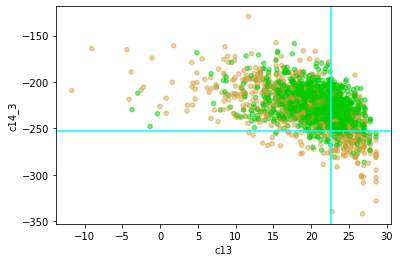

In [28]:
plotdf = sc.get.obs_df(adata3, keys=["c13", "c14_3", 'tumor'])


ahash = {'Tumor':acolor[1],'Normal':acolor[0]}

thr1 = hu.getThrData(plotdf['c13'])
thr2 = hu.getThrData(plotdf['c14_3'])
    
print(thr1)
print(thr2)
c1 = (plotdf['c13'] <= thr1[0])
c2 = (plotdf['c14_3'] <= thr2[0])

c3 = (plotdf['c13'] > thr1[0])
c4 = (plotdf['c14_3'] > thr2[0])

# Second StepMiner

thr3 = hu.getThrData(plotdf[c3]['c13'])
c5 = (plotdf['c13'] <= thr3[0])
c6 = (plotdf['c13'] > thr3[0])


thr4 = hu.getThrData(plotdf[c2]['c14_3'])
c7 = (plotdf['c14_3'] <= thr4[0])
c8 = (plotdf['c14_3'] > thr4[0])


plotdf['color'] = [ahash[k] for k in plotdf['tumor']]
ax=plotdf.plot.scatter("c13", "c14_3", c="color", alpha=0.5, rasterized=True)
ax.axhline(y=thr4[0], color='cyan')
ax.axvline(x=thr3[0], color='cyan')


print(Counter(plotdf[c5 & c7]['tumor']), Counter(plotdf['tumor']))
print(Counter(plotdf[c6 & c8]['tumor']), Counter(plotdf['tumor']))

In [29]:
from statsmodels.stats.proportion import proportions_ztest
stats, pval=proportions_ztest(19, 1170, 32/750)
print(pval)
from statsmodels.stats.proportion import proportions_ztest
stats, pval=proportions_ztest(333, 1170, 130/750)
print(pval)

8.562065210941044e-13
3.293388076201618e-17
